In [59]:
import torch
from torch import nn 
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_circles

SEED = 2697
LR = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

# Lesson 3 PyTorch Neural Network Classification

"What is a classification problem?"
- Is this email spam or not spam? -> binary classification - one thing or another
- Is this a photo of sushi, steak, or pizza? -> multiclass classification - imagenet a great library for multiclass image classification
- What tags should this article have? -> Multilabel classification - Read text - find the most relevant catagory.

binary vs. multiclass

Look at the architecture
- input shapes
- output shape
    - features and models
- Create a custom data set, view it, fit it, predict it
- Steps in modelling
- Save and load models
- Understand some trhings about nonlinearity
- Different methods

## Inputs and Outputs
---------------------

224 x 224 is common dimensions for image classification problems
Generally have 3 channels -  RGB

shape of an iinput tensor 
- [batch_size, color_channels, width, height] 
- [None,3,224,224] or [32,3,224,224]

Yann LeCun - likes batch sizes of around 32 :)
* Some factor of 8 is best

## Architecture of a Classification Model
-------------------------------------------


| **Hyperparameter** | **Binary Classification** | **Multiclass classification** |
| --- | --- | --- |
| **Input layer shape** (`in_features`) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification |
| **Hidden layer(s)** | Problem specific, minimum = 1, maximum = unlimited | Same as binary classification |
| **Neurons per hidden layer** | Problem specific, generally 10 to 512 | Same as binary classification |
| **Output layer shape** (`out_features`) | 1 (one class or the other) | 1 per class (e.g. 3 for food, person or dog photo) |
| **Hidden layer activation** | Usually [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html#torch.nn.ReLU) (rectified linear unit) but [can be many others](https://en.wikipedia.org/wiki/Activation_function#Table_of_activation_functions) | Same as binary classification |
| **Output activation** | [Sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) ([`torch.sigmoid`](https://pytorch.org/docs/stable/generated/torch.sigmoid.html) in PyTorch)| [Softmax](https://en.wikipedia.org/wiki/Softmax_function) ([`torch.softmax`](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) in PyTorch) |
| **Loss function** | [Binary crossentropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_loss_function_and_logistic_regression) ([`torch.nn.BCELoss`](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) in PyTorch) | Cross entropy ([`torch.nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) in PyTorch) |
| **Optimizer** | [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) (stochastic gradient descent), [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) (see [`torch.optim`](https://pytorch.org/docs/stable/optim.html) for more options) | Same as binary classification |




In [60]:
# Start with data!
# We will make our own for this example

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples=n_samples,
                    noise=0.05,
                    random_state=SEED)
print(f"First five samples of X: \n{X[:5]}")
print(f"\nFirst five samples of y: \n{y[:5]}")

First five samples of X: 
[[ 0.45066492 -0.81422714]
 [ 0.24944903 -0.99564631]
 [ 0.0934028  -0.85353239]
 [-0.82892875 -0.34681055]
 [-0.00310174  0.7663215 ]]

First five samples of y: 
[0 0 1 0 1]


In [61]:
# Make a DataFrame of circle data
import pandas as pd

circles = pd.DataFrame({"X1":X[:,0],
                        "X2":X[:,1],
                        "label":y})

circles.head()

,X1,X2,label
0,0.450665,-0.814227,0
1,0.249449,-0.995646,0
2,0.093403,-0.853532,1
3,-0.828929,-0.346811,0
4,-0.003102,0.766321,1


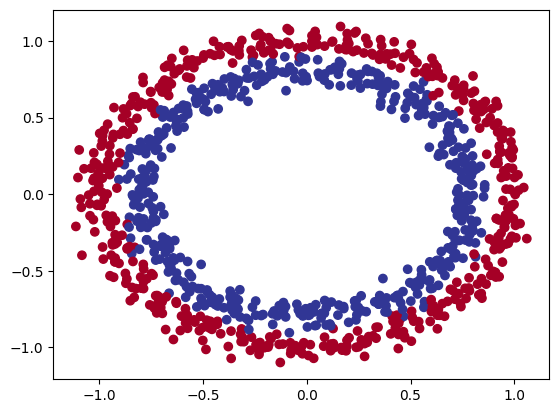

In [62]:
# Let's visualize! Use plt

plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);


This is called  a toy dataset. Datasets you can use to learn

[Toy Datasets from SciKitLearn](https://scikit-learn.org/stable/datasets/toy_dataset.html)

In [63]:
# We need to get this data into a tensor!
# Check input and output shapes
print(f"X is: {X.shape, type(X)}")
print(f"y is: {y.shape, type(y)}")

X is: ((1000, 2), <class 'numpy.ndarray'>)
y is: ((1000,), <class 'numpy.ndarray'>)


In [64]:
# Turn these bad boys into tensors, make sure you turn it into pytorchs default type! 
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[0].dtype, y[:5]

(torch.float32, tensor([0., 0., 1., 0., 1.]))

In [65]:
# Split the data!
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=SEED)


In [66]:
# Build a model 

class CircleModelV0(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        # Create 2 nn.Linear layers
        self.two_linear_layers = nn.Sequential(nn.Linear(in_features=2, out_features=125),
                                                nn.Linear(in_features=125, out_features=1)).to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.two_linear_layers(x) # x -> layer_1 -> layer_2 -> out

model0 = CircleModelV0()



### Some info on loss functions
---------------------------------
* [Binary Cross Entropy Loss](https://towardsdatascience.com/understanding-binary-cross-entropy-log-loss-a-visual-explanation-a3ac6025181a)
* [Logits](https://en.wikipedia.org/wiki/Logit)

In [67]:
# Time to pick a loss function
loss_fn = nn.BCEWithLogitsLoss() # Has the sigmoid activation function built in 

# Pick an optimizer
optimizer = torch.optim.SGD(params=model0.parameters(), 
                            lr=LR)

# Evaluation metric calculate accuracy
# Out of 100 examples what percentage does our model get right
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_true))* 100
    return acc





### Train a model
1. Forward pass
2. Calculate the loss
3. Optimize the zero grad
4. Loss backwards (backpropagation)
5. Step through the optimizer (gradient decent)

In [68]:
# View the first 5 outputs of the forward pass on the test data
model0.eval()
with torch.inference_mode():
    out_logits = model0(X_test.to(device)[:5])

# logits must become probs!
out_probs = torch.sigmoid(out_logits)

# Probs gotta be preds!
out_preds = torch.round(out_probs)
out_preds

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [69]:
# Building a Training and Test loop
epochs = 1000
torch.manual_seed(SEED)

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

def train(model, X_train, X_test, y_train, y_test, epochs, loss_fn, optimizer):
    for epoch in range(epochs):
        # forward pass
        model.train()
        logits = model(X_train).squeeze()
        pred = torch.round(torch.sigmoid(logits)) # logits -> probs -> preds

        # calculate the loss
        loss = loss_fn(logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=pred)

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Testing loop
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_pred)

        # Print out what is going on
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Train Loss: {test_loss:.5f}, Acc: {test_acc:.2f}%")
            
train(model0, X_train, X_test, y_train, y_test, epochs, loss_fn, optimizer)

Epoch: 0 | Loss: 0.75537, Acc: 46.75% | Train Loss: 0.73409, Acc: 48.00%
Epoch: 10 | Loss: 0.75101, Acc: 47.25% | Train Loss: 0.73031, Acc: 49.00%
Epoch: 20 | Loss: 0.74701, Acc: 47.25% | Train Loss: 0.72687, Acc: 49.00%
Epoch: 30 | Loss: 0.74334, Acc: 47.00% | Train Loss: 0.72373, Acc: 49.50%
Epoch: 40 | Loss: 0.73996, Acc: 47.50% | Train Loss: 0.72088, Acc: 50.00%
Epoch: 50 | Loss: 0.73685, Acc: 47.88% | Train Loss: 0.71828, Acc: 49.50%
Epoch: 60 | Loss: 0.73400, Acc: 47.88% | Train Loss: 0.71591, Acc: 49.00%
Epoch: 70 | Loss: 0.73137, Acc: 47.88% | Train Loss: 0.71375, Acc: 49.50%
Epoch: 80 | Loss: 0.72895, Acc: 47.88% | Train Loss: 0.71179, Acc: 49.50%
Epoch: 90 | Loss: 0.72672, Acc: 47.88% | Train Loss: 0.71000, Acc: 50.50%
Epoch: 100 | Loss: 0.72466, Acc: 48.00% | Train Loss: 0.70836, Acc: 50.50%
Epoch: 110 | Loss: 0.72276, Acc: 48.00% | Train Loss: 0.70688, Acc: 50.50%
Epoch: 120 | Loss: 0.72100, Acc: 47.50% | Train Loss: 0.70552, Acc: 51.00%
Epoch: 130 | Loss: 0.71937, Acc: 47.

## We gotta visualize our predictions

From the metrics it looks like our model isn't learning anything...

To do so we are going to import requests and use a function called plot_decision_boundary created by daniel burke

In [70]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
    print("helper_fuinction.py already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


helper_fuinction.py already exists


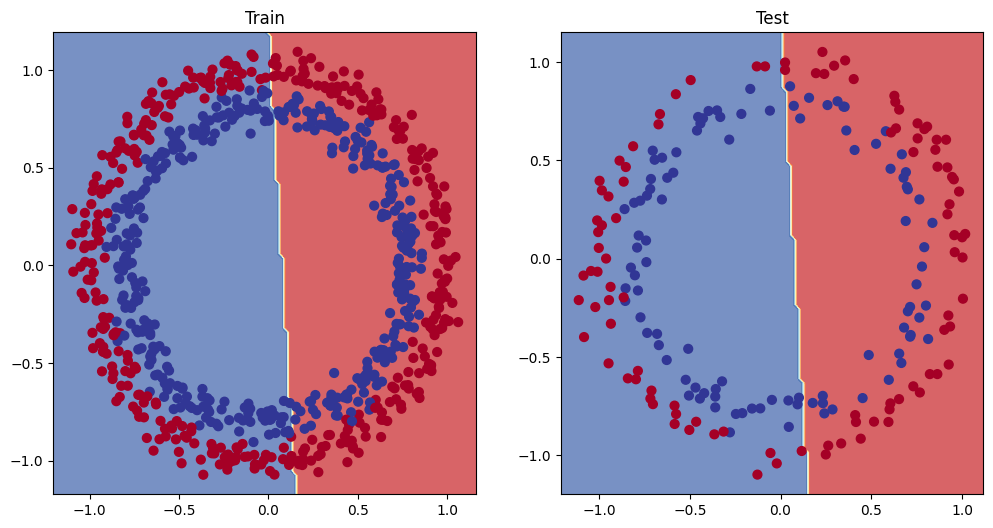

In [71]:
from helper_functions import plot_decision_boundary

# Plot decision boundary
# Checking to 

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

## Improving the model

So as we look at the decision boundary we see that our model is splitting predictions via a linear split but our data pattern is actually circular.. how do we fix this?

(Some of these might not work for this particular example, but worth a shot!)
* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hideen units to 10 hidden units
* Train for longer
* Changing the activation function - we are using sigmoid at the moment...
* Change the learning rate - the rate the optimizer adjusts the model parameters - watch out for exploding gradient problem or vanishing gradient problem!!
* Change the loss function...


In [72]:
# Model V1
# Build a model 

class CircleModelV1(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=125)
        self.layer_2 = nn.Linear(in_features=125, out_features=100)
        self.layer_3 = nn.Linear(in_features=100, out_features=1)

        self.neural_net = nn.Sequential(self.layer_1,
                                        nn.ReLU(), 
                                        self.layer_2,
                                        nn.ReLU(), 
                                        self.layer_3).to(device)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.neural_net(x) # x -> layer_1 -> ReLU -> layer_2 -> ReLU -> layer_3 -> out

model1 = CircleModelV1()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model1.parameters(), lr=.1)
train(model1, X_train, X_test, y_train, y_test, 100, loss_fn, optimizer)

Epoch: 0 | Loss: 0.69266, Acc: 50.00% | Train Loss: 1.60356, Acc: 50.50%
Epoch: 10 | Loss: 0.69500, Acc: 50.25% | Train Loss: 0.68591, Acc: 58.00%
Epoch: 20 | Loss: 0.52563, Acc: 77.00% | Train Loss: 0.49301, Acc: 75.50%
Epoch: 30 | Loss: 0.30820, Acc: 91.25% | Train Loss: 0.27863, Acc: 97.00%
Epoch: 40 | Loss: 0.16529, Acc: 98.38% | Train Loss: 0.16740, Acc: 96.50%
Epoch: 50 | Loss: 0.10196, Acc: 98.25% | Train Loss: 0.14131, Acc: 96.00%
Epoch: 60 | Loss: 0.06968, Acc: 98.75% | Train Loss: 0.12868, Acc: 96.50%
Epoch: 70 | Loss: 0.06405, Acc: 98.25% | Train Loss: 0.13398, Acc: 96.50%
Epoch: 80 | Loss: 0.07851, Acc: 97.12% | Train Loss: 0.16512, Acc: 95.50%
Epoch: 90 | Loss: 0.11169, Acc: 96.38% | Train Loss: 0.17042, Acc: 94.50%


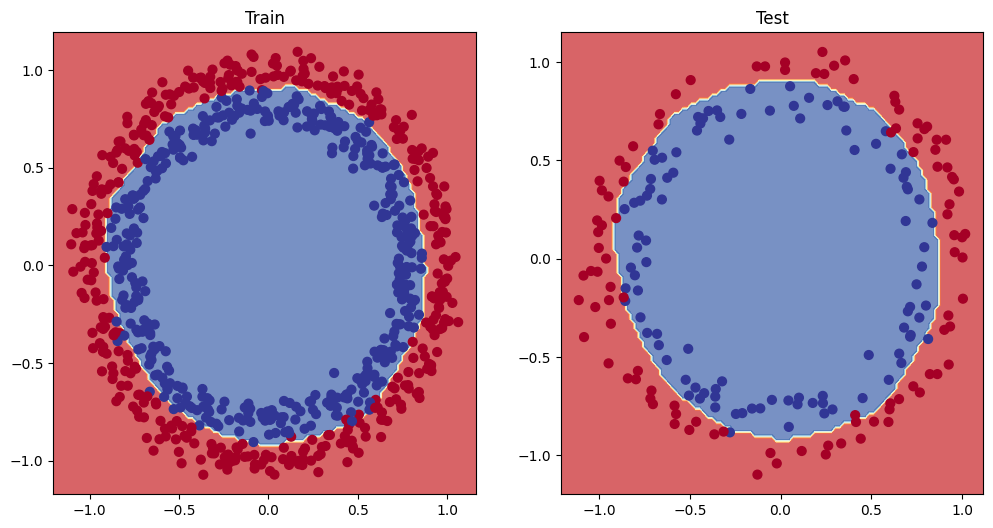

In [73]:
from helper_functions import plot_decision_boundary

# Plot decision boundary
# Checking to 

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

### Putting it all together with a multi-class classification problem

Start by gettin the datasets prepped

In [85]:
from sklearn.datasets import make_blobs
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchmetrics import Accuracy

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 2697

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) # There is a weird dtype issue that led to using torch.LongTensor

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

print(y_blob_test[:5])

tensor([3, 0, 3, 1, 3])


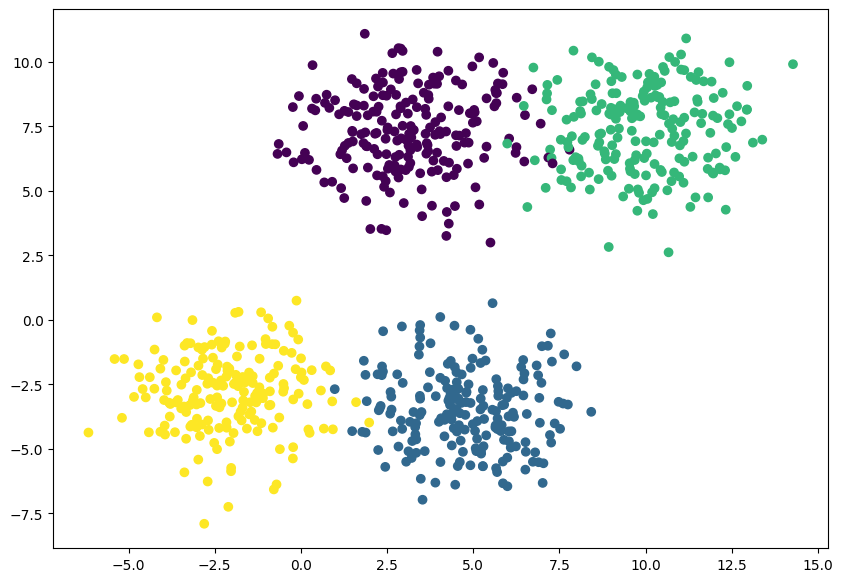

In [75]:
plt.figure(figsize=(10,7))
plt.scatter(X_blob_train[:,0],
            X_blob_train[:,1],
            c=y_blob_train,)

In [84]:
class MultiClassModel(nn.Module):
    def __init__(self, device) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=125)
        self.layer_2 = nn.Linear(in_features=125, out_features=250)
        self.layer_3 = nn.Linear(in_features=250, out_features=4)
        self.activation_func = nn.ReLU()
        self.neuralnet = nn.Sequential(self.layer_1,
                                       self.activation_func,
                                       self.layer_2,
                                       self.activation_func,
                                       self.layer_3).to(device)
    
    def forward(self, x):
        return self.neuralnet(x)

def train(model, X_train, X_test, y_train, y_test, epochs, loss_fn, optimizer):
    for epoch in range(epochs):
        # forward pass
        model.train()
        train_logits = model(X_train).squeeze() 
        # In order to train this model we have to convert these logits from probs to preds, since we have 4 classes
        # Our output of the forward pass has logits for each of the output features, but we need one prediction
        train_pred = torch.softmax(train_logits,dim=1).argmax(dim=1) # logits -> probs -> preds

        # calculate the loss
        loss = loss_fn(train_logits, y_train)
        acc = accuracy_fn(y_true=y_train, y_pred=train_pred)

        # Optimizer zero grad
        optimizer.zero_grad()

        # Loss backward
        loss.backward()

        # Optimizer step
        optimizer.step()

        # Testing loop
        model.eval()
        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_pred = torch.softmax(test_logits,dim=1).argmax(dim=1)
            test_loss = loss_fn(test_logits, y_test)
            test_acc = accuracy_fn(y_test, test_pred)

        # Print out what is going on
        if epoch % 10 == 0:
            print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Train Loss: {test_loss:.5f}, Acc: {test_acc:.2f}%")

torch.manual_seed(RANDOM_SEED)
model2 = MultiClassModel(device)
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(params=model2.parameters(), lr=0.1)

X_blob_train = X_blob_train.to(device)
X_blob_test = X_blob_test.to(device)
y_blob_train = y_blob_train.to(device)
y_blob_test = y_blob_test.to(device)


train(model=model2,
      X_train=X_blob_train,
      X_test=X_blob_test,
      y_train=y_blob_train,
      y_test=y_blob_test,
      epochs=150,
      loss_fn=loss_fn,
      optimizer=optim)

Epoch: 0 | Loss: 1.69302, Acc: 8.62% | Train Loss: 21.00967, Acc: 72.50%
Epoch: 10 | Loss: 1.29143, Acc: 81.62% | Train Loss: 1.01039, Acc: 90.00%
Epoch: 20 | Loss: 0.12058, Acc: 97.38% | Train Loss: 0.17459, Acc: 98.00%
Epoch: 30 | Loss: 0.07164, Acc: 97.88% | Train Loss: 0.08101, Acc: 98.50%
Epoch: 40 | Loss: 0.06335, Acc: 97.62% | Train Loss: 0.09520, Acc: 99.00%
Epoch: 50 | Loss: 0.05368, Acc: 98.50% | Train Loss: 0.03430, Acc: 98.50%
Epoch: 60 | Loss: 0.02666, Acc: 98.88% | Train Loss: 0.00827, Acc: 100.00%
Epoch: 70 | Loss: 0.02537, Acc: 98.88% | Train Loss: 0.01246, Acc: 99.50%
Epoch: 80 | Loss: 0.02288, Acc: 98.88% | Train Loss: 0.00563, Acc: 100.00%
Epoch: 90 | Loss: 0.02130, Acc: 98.88% | Train Loss: 0.00674, Acc: 100.00%
Epoch: 100 | Loss: 0.02088, Acc: 98.88% | Train Loss: 0.00763, Acc: 100.00%
Epoch: 110 | Loss: 0.02049, Acc: 98.88% | Train Loss: 0.00721, Acc: 100.00%
Epoch: 120 | Loss: 0.02019, Acc: 99.00% | Train Loss: 0.00769, Acc: 100.00%
Epoch: 130 | Loss: 0.01999, Ac

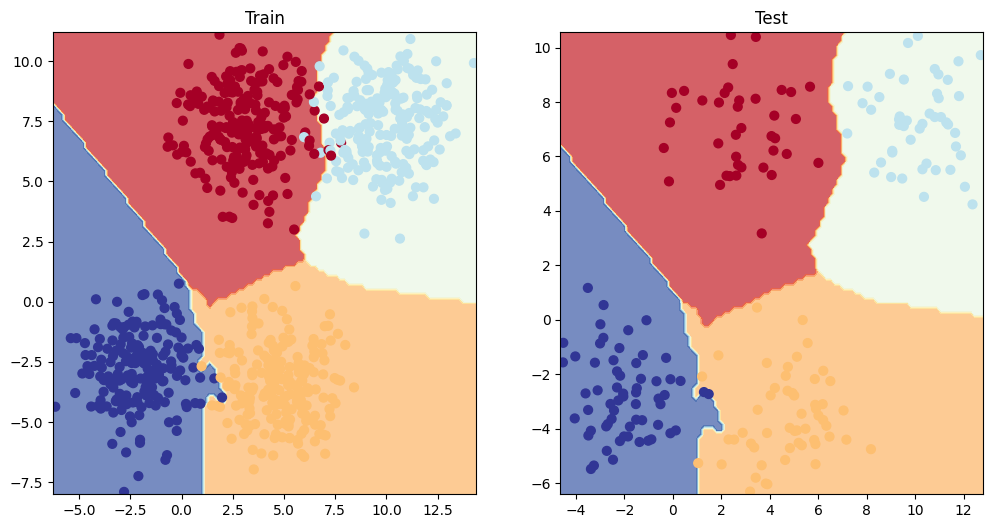

In [81]:
from helper_functions import plot_decision_boundary

# Plot decision boundary
# Checking to 

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model2, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model2, X_blob_test, y_blob_test)

### A few more Classification Metrics

* Accuracy - out of 100 samples how many are right - torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()
* Precision - https://towardsdatascience.com/beyond-accuracy-precision-and-recall-3da06bea9f6c - torchmetrics.Precision() or sklearn.metrics.precision_score() - higher precision leads to less false positives
* Recall - torchmetrics.Recall() or sklearn.metrics.recall_score() - Higher recall leads to less false negatives - precision recall tradeoff
* F1-score - combines precision and recall -  torchmetrics.F1score()
* Confusion Matrix
